*Author*: Patrick Mineault

[Adapted from Kevin Murphy's book in the chapter on MCMC (chapter 24.2)](https://github.com/probml/pmtk3/blob/master/pmtk/examples/isingImageDenoiseDemo.m). 

# Gibbs sampling in an Ising model

Suppose we have a noisy image that we want to denoise. We assume that underlying non-noisy image (the hidden image) is binary, and that the image statistics are defined by pairwise potentials; the Ising model.

We write the image as a vector $\mathbf{x}$. We assume that each element of $\mathbf{x}$ can take the values +1 and -1. We use an Ising model for the underlying field:

$$\log p(\mathbf{x}) = k + \sum_{s \in nbr(t)} \log \phi(x_s, x_t)$$

Where k is an unknown normalization constant, $nbr(\mathbf{x_s})$ is the 4 neighborhood of a point, and $\log \phi(x_s, x_t)$ is a potential:

$$\log \phi(x_s, x_t) = J x_s x_t$$

For simplicity we'll assume $J = 1$. We then assume an iid Gaussian observation model:

$$\mathbf{y} \sim \text{Normal}(\mathbf{x}, \sigma^2)$$

To estimate the underlying model parameters $\mathbf{x}$, proceed by Gibbs sampling. We sample from the conditional distribution of the $t$th pixel given every other parameter and observation. We exploit the conditional independence properties of the model as follows:

The first important thing to note is that this distribution is independent of every observation but the one for the pixel in question:

$$p(x_t|\mathbf{x_{\setminus t}}, \mathbf{y}, J, \sigma) \equiv p(x_t|\mathbf{x_{\setminus t}}, y_t, J, \sigma)$$



That means that for the purpose of conditional sampling, all the other observations don't matter; only the underlying hidden variables matter. The second thing to note is that not all hidden variables matter:

$$p(x_t|\mathbf{x_{\setminus t}}, y_t, J, \sigma) \equiv \prod_{s\in nbr(t)} p(x_t|x_{s}, y_t, J, \sigma)$$

So we only need to look at neighbors of the pixel we're sampling from. What is this probability then? By Bayes' theorem:

$$\prod_{s\in nbr(t)} p(x_t|x_{s}, y_t, J, \sigma) \propto p(y_t|x_t, \sigma) \prod_{s\in nbr(t)} p(x_t|x_{s}, J)$$

Let's normalize this quantity to obtain the conditional probability, which we'll call $q(x_t = +1)$ for short:

$$q(x_t = +1) = \frac{p(y_t|x_t = +1, \sigma) \prod_{s\in nbr(t)} p(x_t = +1|x_{s}, J)}{\sum_{v\in(-1,+1)} p(y_t|x_t = v, \sigma) \prod_{s\in nbr(t)} p(x_n = v|x_{s}, J)}$$

Let's call $\eta_t$ the sum of the values of the neighbors of $n$. Then we have:

$$q(x_t = +1) = \frac{\exp \left(-\frac{1}{2\sigma^2} (y_t - 1) ^ 2 + J\eta_t \right)}{\sum_{v\in(-1,+1)} \exp \left(-\frac{1}{2\sigma^2} (y_t - v) ^ 2 + vJ\eta_t \right)}$$



Finally, if we divide by the numerator, we obtain a familiar sigmoid function:

$$q(x_t = +1) = \text{sigmoid} \left(  2J\eta_t + \frac{2 y_t}{\sigma^2} \right)$$

Sanity checks: 

  * If the observation $y_t$ is positive, it's more likely that the hidden pixel $x_t$ is positive. 
  * If most of its neighbours are positive, it's more likely that the hidden pixel $x_t$ is positive.
  * As the coupling strength $J$ becomes larger, $x$ is more likely to follow its neighbors
  * If the noise is large, we're less likely to follow the neighbours.
  
## Gibbs sampling.

Gibbs sampling simply consists of:

  * For N outer iterations:
    * For k inner iterations corresponding to pixel t
      *  sample from the conditional distribution $q(x_t)$
      
If the chain mixes well, the samples we obtian will be samples from the model posterior, from which we can calculate, e.g. the mean to obtain our best estimate of the image.

Let's start by loading the data and then apply Gibbs sampling to denoise it.

In [0]:
import numpy as np
import StringIO
import matplotlib.pyplot as plt
from PIL import Image

path = 'https://raw.githubusercontent.com/probml/pmtk3/master/data/letterA/letterA.bmp'
sigma = 2

with urllib.urlopen(path) as f:
  im = np.asarray(Image.open(StringIO.StringIO(f.read())))

# Create the image and a noisy version of it.
im = ((im > 128).astype(np.float32) - 0.5) * 2.0
im_noisy = im + sigma*np.random.randn(im.shape[0], im.shape[1])

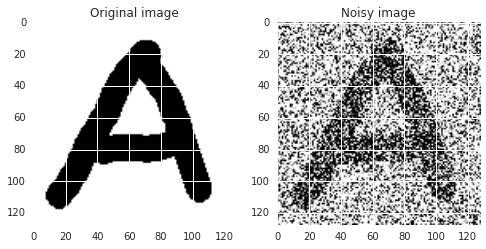

In [141]:
plt.subplot(121)
plt.imshow(im, vmin = -1, vmax=1)
plt.title('Original image')
plt.subplot(122)
plt.imshow(im_noisy, vmin = -1, vmax=1)
plt.title('Noisy image')

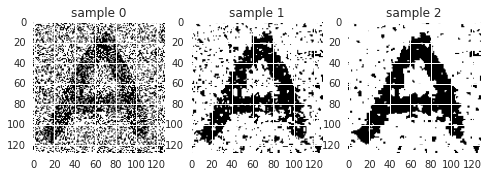

In [142]:
def gibbs_sampler(im, J, sigma, niter):
  # Start somewhere reasonable. 
  # Random would work but would be slower.
  x = ((im > 0).astype(np.float32)) * 2 - 1
  samples = [x.copy()]
  for k in range(niter):
    for i in range(x.shape[0]):
      for j in range(x.shape[1]):
        # Here (i, j) is isomorphic to t
        # Select the neighbors.
        eta = 0
        if i > 0:
          eta += x[i - 1, j]
        if i < x.shape[0] - 1:
          eta += x[i + 1, j]
        if j > 0:
          eta += x[i, j - 1]
        if j < x.shape[1] - 1:
          eta += x[i, j + 1]
        # Compute the energy
        gamma = 2 * J * eta + 2 * im[i, j] / sigma ** 2
        q = 1 / (1 + np.exp(- gamma))
        # And sample from the conditional distribution
        x[i, j] = (np.random.rand() < q) * 2 - 1
    samples.append(x.copy())
  return samples

im_samples = gibbs_sampler(im_noisy, 1, sigma, 2)
plt.subplot(131)
plt.imshow(im_samples[0], vmin=-1, vmax=1)
plt.title('sample 0')
plt.subplot(132)
plt.imshow(im_samples[1], vmin=-1, vmax=1)
plt.title('sample 1')
plt.subplot(133)
plt.imshow(im_samples[2], vmin=-1, vmax=1)
plt.title('sample 2')

We see that very rapidly, the model is moving towards a pretty good guess for the underlying image. Let's see how many iterations is takes to start to settle around the mode of the posterior.

In [0]:
im_samples = gibbs_sampler(im_noisy, 1, sigma, 100)
mse = ((im_samples - im.reshape((1, im.shape[0], im.shape[1])))**2).sum(2).sum(1)

(0, 3000)

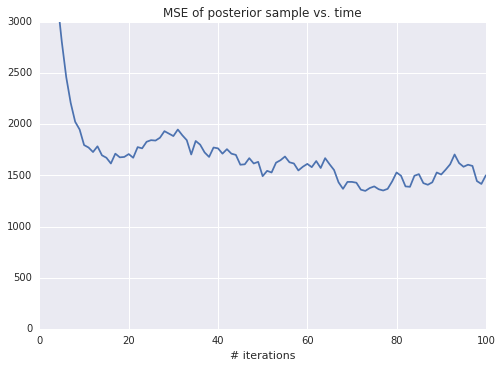

In [144]:
plt.plot(mse)
plt.title('MSE of posterior sample vs. time')
plt.xlabel('# iterations')
plt.ylim((0, 3000))

If I was to eyeball it, I would say that the sampler starts to converge around 20 iterations. It's conventional with MCMC to forget the initial transient samples to focus on the steady state samples after a *burn-in* period. To get an estimate of the posterior of the model, nothing is simpler - just average the samples after the burnin period.

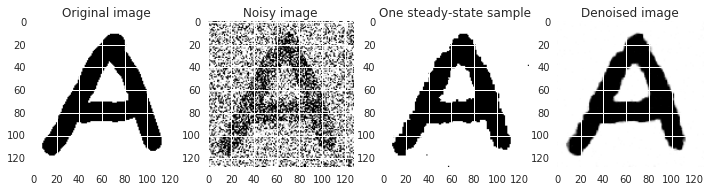

In [145]:
plt.figure(figsize=(12, 4))
burnin = 50
im_denoised = np.array(im_samples[burnin:]).mean(0)
plt.subplot(141)
plt.imshow(im, vmin = -1, vmax=1)
plt.title('Original image')
plt.subplot(142)
plt.imshow(im_noisy, vmin = -1, vmax=1)
plt.title('Noisy image')
plt.subplot(143)
plt.imshow(im_samples[burnin], vmin = -1, vmax=1)
plt.title('One steady-state sample')
plt.subplot(144)
plt.imshow(im_denoised, vmin = -1, vmax=1)
plt.title('Denoised image')

Let's look at the delta between the guessed image and the true image.

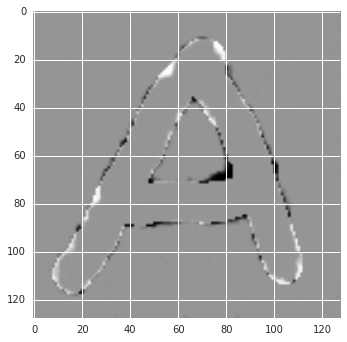

In [146]:
plt.imshow(np.array(im_samples)[burnin:,:,:].mean(0) - im)

![magic](http://i.imgur.com/YsbKHg1.gif)

# À trous blocked Gibbs sampler

That's all well and good, but the sampler is super slow. We could push everything to C, which would definitely help - [Gibbs samplers are notoriously poorly adapted to high-level languages](https://darrenjw.wordpress.com/2011/07/16/gibbs-sampler-in-various-languages-revisited/). 

However, we can take advantage of the conditional independence properties of the graph to speed up the sampling tremendously while keeping in good old Python. The neighborhood potential implies that if two (hidden) pixels lie in each other's neighborhoods, sampling from each other can't be done independently. However, the converse is also true. Recall this equation:

$$p(x_t|\mathbf{x_{\setminus t}}, y_t, J, \sigma) \equiv \prod_{s\in nbr(t)} p(x_t|x_{s}, y_t, J, \sigma)$$

If you squint you will notice that you can sample from the conditional distributions of two pixels *simultaneously* as long as they lie in different neighbordhoods, because these conditional distributions are independent of each other.

In fact, you can sample from 1/4 of the pixels simultaneously, as long as you leave 2 pixels between each hidden variable. You sample from pixel (0, 0), pixel (2, 0), pixel (0, 2), pixel (2, 2), etc. Then you can repeat this 4 times with different offsets. I call this an *à trous* sampler, because of its similarity to an *à trous* or strided convolution.

![a trous](http://i.stack.imgur.com/f2RiP.gif)

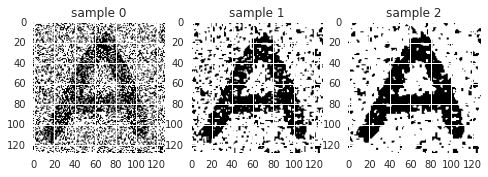

In [173]:
def gibbs_sampler_a_trous(im, J, sigma, niter, stride = 2):
  # Pad the image to avoid edge problems
  im = np.pad(im, (1, 1), 'constant')
  x = np.sign(im)
  samples = [x.copy()]
  for k in range(niter):
    for i in range(stride):
      for j in range(stride):
        # Here (i, j) is isomorphic to t
        # Select the neighbors.
        islice_l = slice(i,     im.shape[0] - 1 + i - stride, 2)
        islice_0 = slice(i + 1, im.shape[0]     + i - stride, 2)
        islice_r = slice(i + 2, im.shape[0] + 1 + i - stride, 2)
        
        jslice_l = slice(j,     im.shape[1] - 1 + j - stride, 2)
        jslice_0 = slice(j + 1, im.shape[1]     + j - stride, 2)
        jslice_r = slice(j + 2, im.shape[1] + 1 + j - stride, 2)
        
        etas = (x[islice_l, jslice_0] + 
                x[islice_r, jslice_0] + 
                x[islice_0, jslice_l] + 
                x[islice_0, jslice_r])
        
        # Compute the energy
        gamma = 2 * J * etas + 2 * im[islice_0, jslice_0] / sigma ** 2
        q = 1 / (1 + np.exp(- gamma))
        
        # And sample from the conditional distribution
        x[islice_0, jslice_0] = np.sign(q - np.random.rand(q.shape[0], q.shape[1]))
        assert np.all(x[:, 0] == 0)
    samples.append(x.copy())
  return np.array(samples)[:,1:-1,1:-1]

im_samples = gibbs_sampler_a_trous(im_noisy, 1, sigma, 2)
plt.subplot(131)
plt.imshow(im_samples[0], vmin=-1, vmax=1)
plt.title('sample 0')
plt.subplot(132)
plt.imshow(im_samples[1], vmin=-1, vmax=1)
plt.title('sample 1')
plt.subplot(133)
plt.imshow(im_samples[2], vmin=-1, vmax=1)
plt.title('sample 2')

The old Gibbs sampler took ~ 250 ms per iteration.

In [0]:
%time im_samples = gibbs_sampler(im_noisy, 1, sigma, 10)

CPU times: user 1.81 s, sys: 31 ms, total: 1.85 s
Wall time: 1.86 s


In [0]:
%time im_samples = gibbs_sampler_a_trous(im_noisy, 1, sigma, 10)

CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 15 ms


The block sampler is 100X faster than the old one. 

In [0]:
im_samples = gibbs_sampler_a_trous(im_noisy, 1, sigma, 100)
mse = ((im_samples - im.reshape((1, im.shape[0], im.shape[1])))**2).sum(2).sum(1)

(0, 3000)

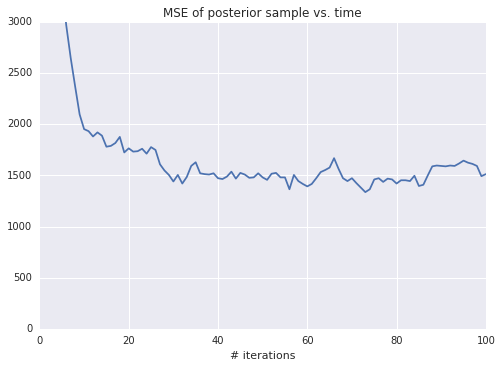

In [168]:
plt.plot(mse)
plt.title('MSE of posterior sample vs. time')
plt.xlabel('# iterations')
plt.ylim((0, 3000))

It converges quite acceptably compared to the pixel-by-pixel solution - in Monto Carlo parlance, the chain is mixing pretty well.

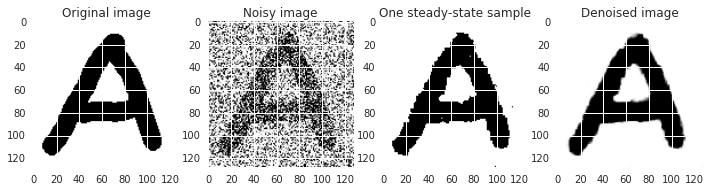

In [171]:
plt.figure(figsize=(12, 4))
burnin = 50
im_denoised = np.array(im_samples[burnin:]).mean(0)
plt.subplot(141)
plt.imshow(im, vmin = -1, vmax=1)
plt.title('Original image')
plt.subplot(142)
plt.imshow(im_noisy, vmin = -1, vmax=1)
plt.title('Noisy image')
plt.subplot(143)
plt.imshow(im_samples[burnin], vmin = -1, vmax=1)
plt.title('One steady-state sample')
plt.subplot(144)
plt.imshow(im_denoised, vmin = -1, vmax=1)
plt.title('Denoised image')

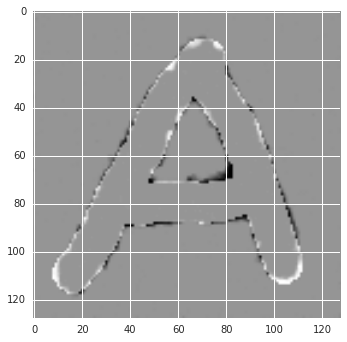

In [172]:
plt.imshow(im_samples[burnin:,:,:].mean(0) - im)

Beautiful!